# Actividad Guiada 1 de Algoritmos de Optimización


Nombre: Carlos Javier Bravo Intriago

https://colab.research.google.com/drive/1O-szoWNwIfQvto4LrLKE7O1djeIBm0kq?usp=sharing

https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025/tree/main/AG1

In [25]:
import timeit
import tracemalloc
import time
from functools import wraps
from typing import List, Union, Tuple, Callable, Optional

from IPython.display import HTML
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np


# -------------------------------- Código Auxiliar -------------------------------- #

HanoiTowerSolutionType = List[Tuple[int, int]]
HanoiTowerCallableType = Callable[[int, int, int, HanoiTowerSolutionType], None]
NQueenSolution = Union[List[int], Tuple[int, ...]]


# Decorador medidor de tiempo
def measure_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        display(HTML(f"Tiempo de ejecucion: {elapsed_time} seg"))
        return result
    return wrapper

# Decorador medidor de Memoria
def measure_memory(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        result = func(*args, **kwargs)
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        # 1 << 10 = 1024, 1 << (10*2) = 1024**2  Conversion a MB
        display(HTML(f"Memoria usada aproximada: {peak/(1<<(10*2))} MB"))
        return result
    return wrapper

# Decorador medidor de tiempo con timeit
# https://stackoverflow.com/a/17579466
def measure_time_accurately(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        start_time = time.time()
        t = timeit.Timer(lambda: func(*args, **kwargs))
        end_time = time.time()
        times = t.repeat(repeat=2, number=1)
        times.append(end_time - start_time)
        avg_time = sum(times) / len(times)
        display(HTML(f"Tiempo de ejecucion: {avg_time} seg"))
        return result
    return wrapper

# método auxiliar para probar las variantes de Torre de Hanoi Propuestas
@measure_time_accurately
def get_hanoi_tower_solutions(
        n: int,
        _from: int,
        to: int,
        hanoi_tower_algorithm: HanoiTowerCallableType
) -> HanoiTowerSolutionType:
    solution = []
    hanoi_tower_algorithm(n, _from, to, solution)
    return solution

def draw_board(
        solution: List[int],
        color_board: Tuple[str, str] = ('#FFCE9E', '#D18B47'),
        ax: Optional[Axes] = None,
) -> Axes:
    """
    - Autor: Carlos Javier Bravo Intriago
    - Fecha: Enero 2026
    -----------------------

    Método que permite dibujar el tablero de ajedrez a la solución definida en `solution` para el problema de las N-Reinas.
    Este código fue parte de otro proyecto personal y ha sido reescrito para representar las posiciones de las reinas.
    Permite resultados `zero-index` o `one-index`.

    -----------------------


    :param solution: Lista con la solución base al modelo [R1, R2, R3, ..., RN] donde cada posición corresponde a su columna, y cada elemento interno corresponde a la fila
    :param color_board: para poder definir el color del tablero, por defecto esta el formato de Lichess.com
    :param ax: Este parametro es opcional, permite agregar este subplot a alguna grafica mas compleja.
    :return: Axes: Retorna el objeto Axes de la figura (Basándose en el Estándar propuesto por Seaborn o Matplotlib)
    """
    n = len(solution)
    starts_with_one = not 0 in solution
    X, Y = np.meshgrid(np.arange(n), np.arange(n))
    board = (X + Y) % 2

    # Seaborn and Matplotlib ecosystem-friendly allows to easily compose complex figures (such as subplots).
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    cmap = ListedColormap(list(color_board))
    ax.imshow(board, cmap=cmap, origin='lower', extent=(0, n, 0, n))

    for col, row in enumerate(solution):
        ax.text(
            col + 0.5 ,
            row + 0.5 - (1 if starts_with_one else 0),
            '♛',
            fontsize=250/n,
            ha='center', va='center',
            color="black"
        )
    # hacky trick for enable horizontal and vertical ticks when ax is defined
    # No reference for this hardcoded part, I only found it through trial and error
    # Carlos Javier Bravo Intriago
    ax.set_xticks(np.arange(0, n, 1))
    ax.set_yticks(np.arange(0, n, 1))
    ax.set_xticks(np.arange(0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(0.5, n, 1), minor=True)

    ax.set_xticklabels([chr(i + 65) for i in range(n)], minor=True)
    ax.set_yticklabels(np.arange(1,n+1), minor=True)
    ax.tick_params(axis='both', which='major', length=0, labelbottom=False, labelleft=False)
    ax.set_title(f"N={n}: Solution {solution}", fontsize=10)
    ax.grid(False)
    return ax

# Torres de Hanoi - Divide y vencerás

<div style="flex: 0 0 200px; text-align: center;">
    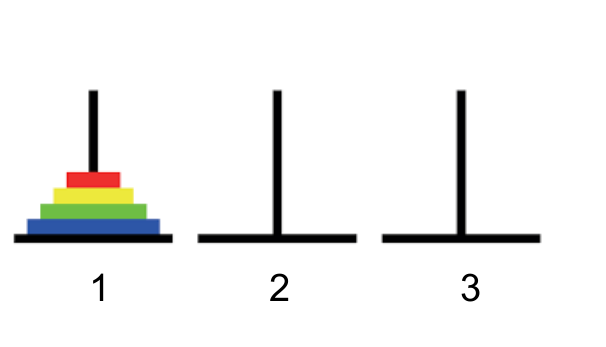
    <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 1. Torres de Hanoi. <i>Adaptado de <a href="img1">[1]</a></i></p>
</div>

<div style="flex: 0 0 200px; text-align: center;">
    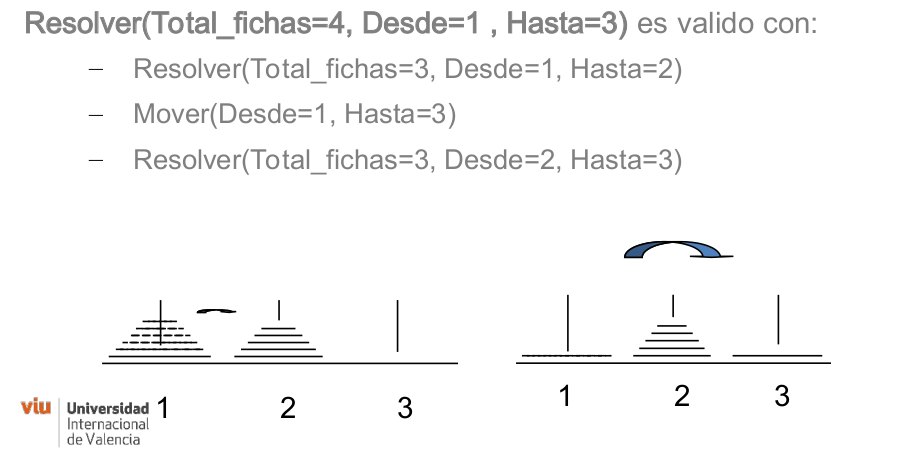
    <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 2. Esquema de resolucion bajo la estrategia de Divide y vencerás</p>
</div>



In [26]:
def hanoi_towers_recursive(n: int, desde: int, hasta: int, sol: HanoiTowerSolutionType) -> None:
    """
    - Autor: Raúl Reyero
    - Modificado por: Carlos Javier Bravo Intriago
    - Fecha: Enero 2026
    -----------------------

    Este algoritmo contempla la misma logica propuesta por el docente Raúl Reyero, con la variante de que no imprime por pantalla el resultado, sino que lo retorna como una lista de tuplas, cada tupla es un par ordenado que representa de que torre a que torre se ha movido la ficha superior.

    Cambios:
    -----------------------
    * Se omite el uso del método `print`
    * Se almacena el resultado en una lista
    * Se usa el operador XOR para buscar la torre o pin auxiliar https://florian.github.io//xor-trick/#application-2-finding-the-missing-number

    :param n: Número de fichas
    :param desde: Torre o pin de Inicio
    :param hasta: Torre o pin final
    :param sol: Referencia de la lista solución, donde se almacenara las tuplas.
    :return: None
    """
    if n==1 :
        sol.append((desde, hasta))
    else:
        pin_auxiliar = desde ^ hasta # Propiedad del operador XOR
        hanoi_towers_recursive(n - 1, desde, pin_auxiliar, sol)
        sol.append((desde, hasta))
        hanoi_towers_recursive(n - 1, pin_auxiliar, hasta, sol)

recursive_solution = get_hanoi_tower_solutions(10, 1, 3, hanoi_towers_recursive)

<div style="flex: 0 0 100px; text-align: center;">
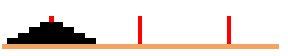
    <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 3. Torres de Hanoi Iterativo. <i>Recuperado de <a href="img2">[2]</a></i></p>
</div>

Se puede resolver el problema de la Torre de Hanoi de manera no recursiva. Teóricamente hablando, el número minimo de movimientos es $2^n-1$, por lo que podría sugerirse que este problema se puede resolver con $2^n-1$ iteraciones.

### Patron encontrado al analizarse los movimientos
TODO: Agregar explicación Iterativa

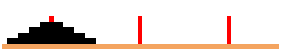

In [27]:
def hanoi_towers_non_recursive(n: int, _from: int, to: int, sol: HanoiTowerSolutionType) -> None:
    """
    - Autor: Vedanti Kshirsagar
    - Corregido y Modificado por: Carlos Javier Bravo Intriago
    - Fuente Original : https://favtutor.com/blogs/tower-of-hanoi
    - Fecha: Enero 2026
    -----------------------

    Variante del algoritmo de las torres de Hanoi no recursiva, basada en la propuesta de Vedanti Kshirsagar, y aplicada las correcciones pertinentes.

    -----------------------

    Cambios / Correcciones:
    -----------------------

    * [1] En el orden de los argumentos de cada if-statement
    * [2] En el resultado final, cuando n es par, se deben intercambiar las torres auxiliar por la del destino
    * [3] Cada iteración puede mover hasta 3 discos (no afecta al rendimiento final teóricamente hablando)

    :param n: Número de fichas
    :param _from: Torre o pin de Inicio
    :param to: Torre o pin final
    :param sol: Referencia de la lista solución, donde se almacenara las tuplas.
    :return: None
    """
    _aux = _from ^ to
    if n % 2 == 0:  # Corrección [2]
        _aux, to = to, _aux  # se podría hacer un swap con el truco XOR
    source = [i + 1 for i in reversed(range(n))]
    target = []
    auxiliary = []

    while True:
        if len(target) == n or len(auxiliary) == n:
            break
        if len(source) != 0 and (len(target) == 0 or source[-1] < target[-1]):  # Corrección [1]
            target.append(source.pop())
            sol.append((_from, to))
        else:
            source.append(target.pop())
            sol.append((to, _from))
        if len(target) == n or len(auxiliary) == n:
            break
        if len(auxiliary) != 0 and (len(source) == 0 or auxiliary[-1] < source[-1]):  # Corrección [1]
            source.append(auxiliary.pop())
            sol.append((_aux, _from))
        else:
            auxiliary.append(source.pop())
            sol.append((_from, _aux))
        if len(target) == n or len(auxiliary) == n:
            break
        if len(target) != 0 and (len(auxiliary) == 0 or target[-1] < auxiliary[-1]):  # Corrección [1]
            auxiliary.append(target.pop())
            sol.append((to, _aux))
        else:
            target.append(auxiliary.pop())
            sol.append((_aux, to))

non_recursive_solution = get_hanoi_tower_solutions(10, 1, 3, hanoi_towers_non_recursive)

In [28]:
# validación de respuestas
# esto debería arrojar una Excepción AssertError si no coinciden las respuestas
assert recursive_solution == non_recursive_solution

# Cambio de monedas - Técnica voraz

In [29]:
SISTEMA = [50,20,10,5,1]

def cambio_monedas(cantidad: int, sistema_monetario: List[int]) -> Optional[List[int]]:
    """
    - Autor: Raúl Reyero
    - Modificado por: Carlos Javier Bravo Intriago
    - Fecha: Enero 2026
    -----------------------

    (Este algoritmo contempla la misma logica propuesta por el docente Raúl Reyero)

    Algoritmo de cambio de monedas con técnica voraz. Es pertinente tener los valores del `sistema_monetario` monetario ordenados descendentemente, sino este algoritmo deja de funcionar de forma voraz

    -----------------------
    :param cantidad: Valor en entero de la cantidad que se desea generar el `cambio`
    :param sistema_monetario: Lista de valores correspondientes al sistema monetario, esta lista debe estar ordenada descendentemente
    :return: Lista de cantidades por monedas en el orden establecido en `sistema_monetario`
    """
    sistema_monetario.sort(reverse=True)
    solucion = [0]*len(sistema_monetario)
    valor_acumulado = 0

    for i,valor in enumerate(sistema_monetario):
        monedas = (cantidad - valor_acumulado) // valor
        solucion[i] = monedas
        valor_acumulado = valor_acumulado + monedas*valor

        if cantidad == valor_acumulado:
            return solucion

    print("No es posible encontrar solucion")
    return None

cambio_monedas(cantidad=57, sistema_monetario=SISTEMA)

[1, 0, 0, 1, 2]

# N Reinas - Vuelta Atrás(Backtracking)

<div style="flex: 0 0 200px; text-align: center;">
        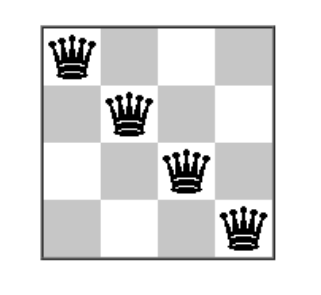
        <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 4. Problema de las N Reinas.</p>
    </div>
</div>

In [30]:
def es_prometedora(solucion_parcial: List[int], etapa: int) -> bool:
    """
    Método para verificar si en la `solucion_parcial` no existe amenazas entre reinas.

    :param solucion_parcial: Solución parcial a verificar
    :param etapa: Etapa en la que se encuentra actualmente el algoritmo
    :return: True o False
    """
    for i in range(etapa+1):
        if solucion_parcial.count(solucion_parcial[i]) > 1:
            return False
        for j in range(i+1, etapa +1 ):
            if abs(i-j) == abs(solucion_parcial[i] - solucion_parcial[j]) : return False
    return True

def reinas(n: int, soluciones: List[NQueenSolution], backtracking: Optional[NQueenSolution] = None, etapa: int = 0):
    """
    - Autor: Raúl Reyero
    - Modificado por: Carlos Javier Bravo Intriago
    - Fecha: Enero 2026
    -----------------------

    Este método contempla la misma logica propuesta por el docente Raúl Reyero aplicando la estrategia de BackTracking, con la variante de que no imprime por pantalla el resultado, sino que se agrega una lista auxiliar para encolar las soluciones que se encuentren durante el proceso de backtracking.

    Cambios:
    -----------------------
    * Se omite el uso del método `print`
    * Se almacena el resultado en una lista

    :param n: Número de reinas
    :param soluciones: Lista (o referencia de la misma) donde se almacenara las soluciones que el algoritmo vaya encontrando
    :param backtracking: Lista (o referencia de la misma) donde se almacena las iteraciones del backtracking, Por defecto es None
    :param etapa: Etapa en la que se encuentra actualmente el algoritmo
    :return: None
    """
    if backtracking is None:
        backtracking = [0 for _ in range(n)]

    for i in range(1, n + 1):
        backtracking[etapa] = i
        if es_prometedora(backtracking, etapa):
            if etapa == n-1:
                soluciones.append(backtracking.copy())
            else:
                reinas(n, soluciones, backtracking, etapa + 1)
    backtracking[etapa] = 0

@measure_time_accurately
def resolver_reinas(n):
    soluciones = []
    reinas(n, soluciones, etapa=0)
    return soluciones

reinas = resolver_reinas(10)
print(f"Se han encontrado {len(reinas)} soluciones, se imprime la primera de ellas: {reinas[0]}")

Se han encontrado 724 soluciones, se imprime la primera de ellas: [1, 3, 6, 8, 10, 5, 9, 2, 4, 7]


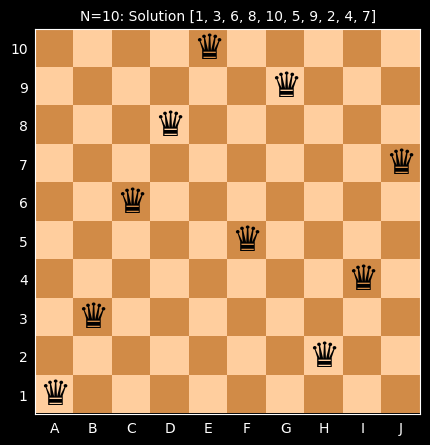

In [31]:
draw_board(reinas[0])
plt.show()

## Propuesta del estudiante:

La implementación de este código see tomó como inspiración de la descripción informal de la técnica de backtracking presentada por Knuth D, en [[3](#DK3)], la descripción original hacia dicha poda después de ampliar la frontera. En esta variante propuesta, se poda a la vez que se amplía la frontera. (En [Wikipedia](https://en.wikipedia.org/wiki/Eight_queens_puzzle#Sample_program) se puede encontrar la transcripción a la descripción informal de Knuth D).

El método `validate_solution` en la version de Knuth D [[3](#DK3)], implica una complejidad temporal $O(N^2)$, ya que recorre la solución a validar en dos ciclos _for_ anidados. Esta nueva propuesta requiere únicamente un ciclo _for_, esto debido a que se pasa como argumento la `current_queen_row` que se pretende encolar, con ello solo basta ir de la `solution` anterior iterar `row` por `row` para validar si la nueva propuesta de `current_queen_row` ataca a alguna otra reina dentro de `solution`.

#### Análisis temporal:
El coste temporal del método `validate_solution` es $O(N)$.

El coste de hacer backtracking a este problema es teóricamente de $O(N!)$

Por cada iteración dentro del backtracking se llama al método `validate_solution`, lo cual implica que la complejidad temporal es $O(N \times N!)$.


In [32]:
@measure_time_accurately
def solve_n_queens(n: int) -> List[NQueenSolution]:
    """
    - Idea Original: Donald Knuth, inspirado y modificado del código disponible en Wikipedia
    - Modificación: Carlos Javier Bravo Intriago
    - Fecha: Enero 2026
    -----------------------

    Propuesta optimizada para el problema de las N-Reinas basado en la estrategia de BackTracking.

    Esta implementación se basa en la idea original de Donald Knuth, pero se introduce mejoras significativas que influyen en la complejidad temporal. A diferencia de la version original que valida soluciones en tiempo cuadrático (O(N²)), esta variante logra una validación en tiempo lineal (O(N)).

    -----------------------

    Cambios / Correcciones:
    -----------------------

    * [1] `extend_with_valid_solutions` filtra las soluciones inválidas durante la construcción de nuevas permutaciones, evitando expandir ramas innecesarias del arbol.
    * [2] `validate_solution` reduce el costo computacional, ahora es de complejidad lineal.

    :param n: Número de Reinas
    :return: Lista con las posibles configuraciones donde las reinas no se atacan mutuamente.
    """
    if n == 1: return [[0]]  # una unica reina
    if n in [2, 3]: return []  # no existe solucion con 2 o 3 reinas
    solution = [[]]
    for i in range(n):
        solution = _extend_with_valid_solutions(solution, n)
    return solution

# Aquí el método validate_solution es de complejidad lineal, se ha quitado la búsqueda redundante por casos ya conocidos
def _validate_solution(solution: NQueenSolution, current_queen_row: int) -> bool:
    """
    Método que valida si la nueva posición `current_queen_row` no entra en conflicto con la `solution` existente
    :param solution:  Lista de enteros con posiciones validas.
    :param current_queen_row: Valor que se desea validar si no genera amenazas entre las otras reinas existentes en `solution`.
    :return: True o False.
    """
    current_col = len(solution)
    for col, row in enumerate(solution):
        if row == current_queen_row:
            return False
        if abs(current_col - col) == abs(current_queen_row - row):
            return False
    return True

def _extend_with_valid_solutions(previous_permutation: list, n: int) -> List[NQueenSolution]:
    """
    Método que expande el arbol o las permutaciones posibles solo si son válidas. Esto evita la generación de nuevas ramas o permutaciones que no conllevaran a alguna solución.
    :param previous_permutation: Permutaciones previas o soluciones previas validadas.
    :param n: Numero de reinas
    :return:
    """
    new_perm = []
    for p in previous_permutation:
        for i in range(n):
            if _validate_solution(p, i):
                extended_array = p + [i]
                new_perm.append(extended_array)
    return new_perm

queens = solve_n_queens(10)
print(f"Se han encontrado {len(queens)} soluciones, se imprime la primera de ellas: {queens[0]}")

Se han encontrado 724 soluciones, se imprime la primera de ellas: [0, 2, 5, 7, 9, 4, 8, 1, 3, 6]


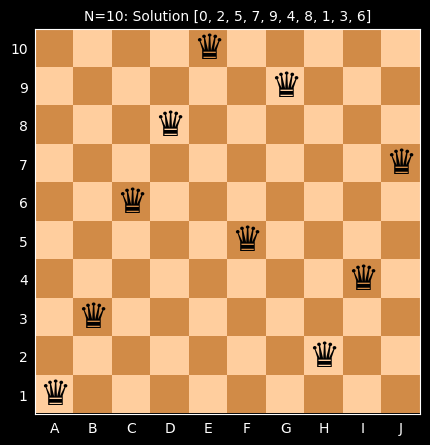

In [33]:
draw_board(queens[0])
plt.show()

# Encontrar los dos puntos más cercanos

Dado un conjunto de puntos se trata de encontrar los dos puntos más cercanos entre sí.


In [34]:
import random

PointType = Union[int, Tuple[int, ...]]
PointsListType = List[PointType]
ResultType = Optional[Tuple[PointType, PointType]]

def random_list_generator(start: int = 1, stop: int = 10_000, n: int = 1_000, dim: int = 1):
    if dim == 1:
        return [random.randrange(start, stop) for _ in range(n)]
    return [tuple([random.randrange(start, stop) for _ in range(dim)]) for _ in range(n)]

def get_square_distance(p: PointType, q: PointType) -> int:
    # es computacionalmente innecesario calcular la raiz cuadrada de la
    # hipotenusa, basta con tener la suma de los cuadrados, y comparar con
    # estos
    r = 0
    _ = [r := r + (i - j)**2 for i, j in zip(p, q)] # Operador Walrus, y List Comprehension
    return r

def get_scalar_distance(p: PointType, q: PointType) -> int:
    return abs(p - q)

#  método para validar si la solucion a uno de los algoritmos esta dentro de todas las posibles soluciones de puntos cercanos
def search_all_closest_pair_brute_force(points: PointsListType) -> List[ResultType]:
    _points = sorted(points)
    if 0 <= len(_points) <= 1:
        return []
    if len(_points) == 2:
        return [(_points[0], _points[1])]
    callback = get_scalar_distance if isinstance(_points[0], int) else get_square_distance
    lowest_dist = float('inf')
    result_points = []
    for left in range(len(_points) - 1):
        for right in range(left + 1 , len(_points)):
            distance = callback(_points[left], _points[right])
            if distance == lowest_dist:
                result_points.append((_points[left], _points[right]))
            if distance < lowest_dist:
                result_points = [(_points[left], _points[right])]
                lowest_dist = distance
    return result_points

## Caso 1: Puntos en una dimension (1D)

<div style="flex: 0 0 300px; text-align: center;">
    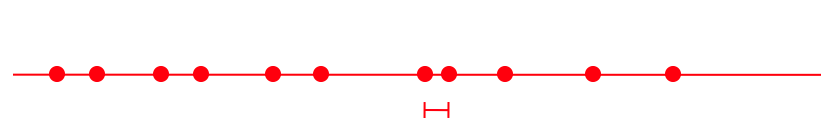
    <p style="text-align: center; font-size: 0.85em; margin-top: 5px; line-height: 1.2;">Fig 5. Dos puntos mas cercanos en una dimension.</p>
</div>

In [35]:
random_points_1d = random_list_generator(stop = 1_000_000, n=1_000, dim=1)
all_nearest_points = search_all_closest_pair_brute_force(random_points_1d)

### Fuerza Bruta:

#### Complejidad Temporal:

Para este caso, que se compara todos contra todos, por cada elemento del arreglo, se compara con los $N-k$ elementos restantes, donde $k$ es el $k$-ésimo termino o número del arreglo.

Por ende, la complejidad temporal es Cuadrática $O(N^2)$

In [36]:
def _search_closest_pair_brute_force(
        points: PointsListType,
        distance_func: Callable[[PointType, PointType], int] = get_scalar_distance
) -> Tuple[ResultType, int]:
    if 0 <= len(points) <= 1:
        return None, 0
    if len(points) == 2:
        return (points[0], points[1]), distance_func(points[0], points[1])
    lowest_dist = float('inf')
    result_points = None
    for left in range(len(points) - 1):
        for right in range(left + 1 ,len(points)):
            distance = distance_func(points[left], points[right])
            if distance < lowest_dist:
                result_points = (points[left], points[right])
                lowest_dist = distance
    return result_points, distance_func(*result_points)

@measure_time_accurately
def search_closest_pair_brute_force(
        points: PointsListType,
        distance_func: Callable[[PointType, PointType], int] = get_scalar_distance
) -> ResultType:
    return _search_closest_pair_brute_force(points, distance_func)[0]

solution = tuple(sorted(search_closest_pair_brute_force(random_points_1d)))
print(solution)
assert solution in all_nearest_points

(41303, 41303)


### Divide y Vencerás:

#### Complejidad Temporal

Se aplica la estrategia Divide y Vencerás, se divide el arreglo en dos partes de manera recursiva, y se obtiene la distancia minima entre estas dos particiones.

Previo a la division del array en dos partes, se debe ordenar la lista de números, lo cual requiere una complejidad de $O(N \log N)$,

Por cada paso o iteración, el algoritmo genera 2 nuevas particiones:

$$
T(N) = 2\cdot T(N/2) = O(N\log N)
$$

Tomando en cuenta el ordenamiento previo, se combinan ambas complejidades, y asintóticamente la complejidad resultante es $O(N\log N)$.



In [37]:
def _search_closest_pair_scalar_divide_and_conquer(points: PointsListType) -> Tuple[ResultType, int]:
    n = len(points)
    if n == 1:
        return None, 0
    if n == 2: # base case
        return (points[0], points[1]), get_scalar_distance(points[0], points[1])
    middle = n >> 1
    left_partition = points[: middle + 1]
    if n & 1 == 0:
        right_partition = points[middle - 1: ]
    else:
        right_partition = points[middle: ]
    left_points, left_distance = _search_closest_pair_scalar_divide_and_conquer(left_partition)
    right_points, right_distance = _search_closest_pair_scalar_divide_and_conquer(right_partition)
    if left_distance < right_distance:
        return left_points, left_distance
    return right_points, right_distance

@measure_time_accurately
def search_closest_pair_scalar_divide_and_conquer(points: PointsListType) -> ResultType:
    _points = sorted(points)
    return _search_closest_pair_scalar_divide_and_conquer(_points)[0]

solution = search_closest_pair_scalar_divide_and_conquer(random_points_1d)
print(solution)
assert solution in all_nearest_points

(894688, 894688)


## ¿Se puede mejorar?

Para el caso de una sola dimension, sí es posible mejorar a penas un poco, basta con que se ordene la lista, y se iteren dos elementos contiguos, es decir, basta un solo ciclo `for` y comparar el punto actual con el punto siguiente de la lista para determinar el par de puntos más cercanos.

Teóricamente, también es de complejidad $O(N\log N)$, sin embargo, esta variante no tiene costos ocultos como la variante aplicada la estrategia de Divide y Vencerás. Los `slicings` son una copia de una parte del array, esta copia es generalmente de complejidad lineal.

In [38]:
@measure_time_accurately
def search_closest_pair_scalar_naive(points: PointsListType) -> ResultType:
    _points = sorted(points)
    lowest_dist = float('inf')
    result_points = None
    for i in range(len(_points) - 1):
        distance = get_scalar_distance(_points[i], _points[i + 1])
        if distance < lowest_dist:
            result_points = (_points[i], _points[i+1])
            lowest_dist = distance
    return result_points

solution = search_closest_pair_scalar_naive(random_points_1d)
print(solution)
assert solution in all_nearest_points

(41303, 41303)


## Extender el algoritmo a 2D

In [39]:
random_points_2d = random_list_generator(stop = 1_000_000, n=1_000, dim=2)
all_nearest_points = search_all_closest_pair_brute_force(random_points_2d)

## Fuerza Bruta

Este caso es similar al de 1D, al final se busca comparar todos contra todos, por cada elemento del arreglo, se compara con los $N-k$ elementos restantes, donde $k$ es el $k$-ésimo termino o número del arreglo.

Por ende, la complejidad temporal es Cuadrática $O(N^2)$ también.

In [40]:
solution = tuple(sorted(search_closest_pair_brute_force(random_points_2d, distance_func=get_square_distance)))
print(solution)
assert solution in all_nearest_points

((75975, 801081), (76062, 801010))


## Divide y vencerás

In [41]:
def _search_closest_pair_2d(x_sorted_points: PointsListType, y_sorted_points: PointsListType) -> Tuple[PointType, PointType, int]:
    n = len(x_sorted_points)
    if n <= 3:  # Base case
        points, best_dist = _search_closest_pair_brute_force(x_sorted_points, distance_func=get_square_distance)
        return points[0], points[1], best_dist

    middle = n >> 1
    mid_point = x_sorted_points[middle]
    left_x_partition = x_sorted_points[: middle]
    right_x_partition = x_sorted_points[middle:]
    left_y_partition, right_y_partition = [], []
    left_set = set(left_x_partition)
    for point in y_sorted_points:
        (left_y_partition if point in left_set else right_y_partition).append(point)

    p1_left, p2_left, dist_left = _search_closest_pair_2d(left_x_partition, left_y_partition)
    p1_right, p2_right, dist_right = _search_closest_pair_2d(right_x_partition, right_y_partition)

    if dist_left < dist_right:
        best_p1, best_p2, best_dist= p1_left, p2_left, dist_left
    else:
        best_p1, best_p2, best_dist= p1_right, p2_right, dist_right

    # Dado que se omite el cálculo de raíces cuadradas,
    # la comparación mid_point[0]-sqrt(dist) < point[0] < mid_point[0]+sqrt(dist) se puede
    # reescribir como dist > (point[0] - mid_point[0])**2
    in_band = [point for point in y_sorted_points if best_dist > (point[0] - mid_point[0])**2]

    for i in range(len(in_band)):
        for j in range(i+1, min(i+7, len(in_band))):
            d = get_square_distance(in_band[i], in_band[j])
            if d < best_dist:
                best_p1, best_p2, best_dist = in_band[i], in_band[j], d

    return best_p1, best_p2, best_dist

@measure_time_accurately
def search_closest_pair_2d_divide_and_conquer(points: PointsListType) -> ResultType:
    x_sorted_points = sorted(points, key=lambda point: point[0])
    y_sorted_points = sorted(points, key=lambda point: point[1])
    p1, p2, dist = _search_closest_pair_2d(x_sorted_points, y_sorted_points)
    return p1, p2

solution = search_closest_pair_2d_divide_and_conquer(random_points_2d)
print(solution)
assert solution in all_nearest_points

((75975, 801081), (76062, 801010))


## Extender el algoritmo a 3D

In [42]:
random_points_3d = random_list_generator(stop = 1_000_000, n=1_000, dim=3)
all_nearest_points = search_all_closest_pair_brute_force(random_points_3d)

## Fuerza Bruta


In [43]:
solution = tuple(sorted(search_closest_pair_brute_force(random_points_3d, distance_func=get_square_distance)))
print(solution)
assert solution in all_nearest_points

((413061, 372334, 930522), (418391, 372402, 929679))


In [44]:
def _search_closest_pair_3d(x_sorted_points: PointsListType, y_sorted_points: PointsListType, z_sorted_points: PointsListType) -> Tuple[PointType, PointType, int]:
    n = len(x_sorted_points)
    if n <= 3:
        points, dist = _search_closest_pair_brute_force(x_sorted_points, distance_func=get_square_distance)
        return points[0], points[1], dist
    middle = n >> 1
    mid_point = x_sorted_points[middle]
    left_x_partition = x_sorted_points[:middle]
    right_x_partition = x_sorted_points[middle:]
    left_y_partition, right_y_partition = [], []
    left_z_partition, right_z_partition = [], []

    left_set = set(left_x_partition)
    for p in y_sorted_points:
        (left_y_partition if p in left_set else right_y_partition).append(p)
    for p in z_sorted_points:
        (left_z_partition if p in left_set else right_z_partition).append(p)

    p1_left, p2_left, dist_left = _search_closest_pair_3d(left_x_partition, left_y_partition, left_z_partition)
    p1_right, p2_right, dist_right = _search_closest_pair_3d(right_x_partition, right_y_partition, right_z_partition)

    if dist_left < dist_right:
        best_p1, best_p2, best_dist = p1_left, p2_left, dist_left
    else:
        best_p1, best_p2, best_dist = p1_right, p2_right, dist_right

    # Dado que se omite el cálculo de raíces cuadradas,
    # la comparación abs(p[0] - mid_point[0]) < best_dist se puede
    # reescribir como (p[0] - mid_point[0])**2 < best_dist
    # El criterio cambia, en vez de ser una franja, ahora es una losa, una superficie o área
    slab_y = [p for p in y_sorted_points if (p[0] - mid_point[0])**2 < best_dist]

    size_slab = len(slab_y)
    for i in range(size_slab):
        for j in range(i + 1, min(i + 16, size_slab)):
            p_i = slab_y[i]
            p_j = slab_y[j]
            if (p_j[1] - p_i[1])**2 >= best_dist:
                break
            if (p_j[2] - p_i[2])**2 >= best_dist:
                continue
            d_sq = get_square_distance(p_i, p_j)
            if d_sq < best_dist:
                best_dist = d_sq
                best_p1, best_p2 = p_i, p_j
    return best_p1, best_p2, best_dist


@measure_time_accurately
def search_closest_pair_3d_divide_and_conquer(points: PointsListType) -> ResultType:
    x_sorted_points = sorted(points, key=lambda point: point[0])
    y_sorted_points = sorted(points, key=lambda point: point[1])
    z_sorted_points = sorted(points, key=lambda point: point[2])
    p1, p2, dist = _search_closest_pair_3d(x_sorted_points, y_sorted_points, z_sorted_points)
    return p1, p2

solution = search_closest_pair_3d_divide_and_conquer(random_points_3d)
print(solution)
assert solution in all_nearest_points

((413061, 372334, 930522), (418391, 372402, 929679))


# Nota sobre el uso de herramientas de IA generativa <a id="ia"></a>

# ACTUALIZAR ESTE RUBRO, se ha usado IA para la síntesis de complejidad para el problema de los puntos cercanos en 3D, y guias de implementacion para encotnrar puntos cercanos en 3D.

En la elaboración de este notebook se utilizaron herramientas de inteligencia artificial generativa de forma puntual y limitada, exclusivamente como apoyo para la definición de estructuras HTML con fines de presentación.

La redacción del contenido, el desarrollo del código, el diseño del análisis y la interpretación de los resultados son de autoría propia, o se basan en material proporcionado en clase y en recursos disponibles públicamente en línea, los cuales han sido reelaborados y adaptados para los objetivos de este trabajo.

# Referencias Bibliográficas

* [1<a id="img1"></a>] "Anónimo", "Hanoi Towers" Imgur, Octubre 2017. [Imagen en línea]. Disponible en: [https://imgur.com/qslq5kH](https://imgur.com/qslq5kH).
* [2<a id="img2"></a>] Weisstein, Eric W, "Tower of Hanoi" Wolfram Mathworld. [Imagen en línea]. Disponible en: [https://mathworld.wolfram.com/TowerofHanoi.html](https://mathworld.wolfram.com/TowerofHanoi.html).
* [3<a id="DK3"></a>] D. E. Knuth, The Art of Computer Programming, Volume 4A: Combinatorial Algorithms, Part 1. Upper Saddle River, NJ, USA: Addison-Wesley Professional, 2011, sec. 7.2.2, p. 31.
*